In [2]:

# import mlflow
# mlflow.set_tracking_uri("http://localhost:5000")
# mlflow.sklearn.autolog()

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder



# 📋 Evaluation Function
def eval_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<20} | MSE: {mse:.4f} | R²: {r2:.4f}")


dataPath = os.path.join("./../data")


## Establishing base lines

In [3]:
clean_df=pd.read_parquet(f'{dataPath}/clean_sample.parquet')

In [3]:

corr = clean_df[["tip_to_fare","tip_amount",'passenger_count',"trip_distance","fare_amount","duration_s",'Airport_flag','congestion_surcharge_flag','mta_tax_flag']].corr()
corr.style.background_gradient(cmap='coolwarm')

,tip_to_fare,tip_amount,passenger_count,trip_distance,fare_amount,duration_s,Airport_flag,congestion_surcharge_flag,mta_tax_flag
tip_to_fare,1.000000,0.078577,-0.005740,-0.170490,-0.277001,-0.121812,-0.109004,0.094406,0.058073
tip_amount,0.078577,1.000000,0.039687,0.606683,0.867011,0.288270,0.601041,-0.287771,-0.281754
passenger_count,-0.005740,0.039687,1.000000,0.027458,0.043376,0.024968,0.016800,-0.002099,-0.036001
trip_distance,-0.170490,0.606683,0.027458,1.000000,0.687364,0.226196,0.517914,-0.243923,-0.144400
fare_amount,-0.277001,0.867011,0.043376,0.687364,1.000000,0.327870,0.645451,-0.360140,-0.347990
duration_s,-0.121812,0.288270,0.024968,0.226196,0.327870,1.000000,0.207864,-0.074621,-0.042626
Airport_flag,-0.109004,0.601041,0.016800,0.517914,0.645451,0.207864,1.000000,-0.419893,-0.040894
congestion_surcharge_flag,0.094406,-0.287771,-0.002099,-0.243923,-0.360140,-0.074621,-0.419893,1.000000,0.310057
mta_tax_flag,0.058073,-0.281754,-0.036001,-0.144400,-0.347990,-0.042626,-0.040894,0.310057,1.000000


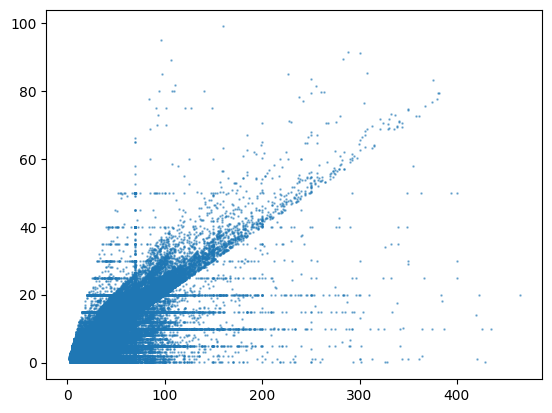

In [36]:
plt.scatter(clean_df['fare_amount'],clean_df['tip_amount'],s=0.6,alpha=0.5)

My first intuition looking the highly correlated values of tip amount and fare_amount,trip_distance is to try to fit a linear model on the data and see how it behaves. So first we will create a simple linear regression model that will be our base model. Did a test with fare amount and trip duration but the coefficient for the trip duration was extremly low. 

In [5]:
#split the df two to parts 
X=clean_df[["fare_amount",'Airport_flag','trip_distance','congestion_surcharge_flag','mta_tax_flag']]
y=clean_df[["tip_amount"]]

# 🪓 Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:

# 📊 Baseline 1: Dummy Mean Regressor
mean_model = DummyRegressor(strategy="mean")
mean_model.fit(X_train, y_train)
y_pred_mean = mean_model.predict(X_test)

# 📊 Baseline 2: Dummy Median Regressor
median_model = DummyRegressor(strategy="median")
median_model.fit(X_train, y_train)
y_pred_median = median_model.predict(X_test)

# 📈 Baseline 3: Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)

# 🌳 Baseline 4: Simple Decision Tree
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)


# 🧾 Report
print("Model Evaluation:")
eval_model("Dummy Mean", y_test, y_pred_mean)
eval_model("Dummy Median", y_test, y_pred_median)
eval_model("Linear Regression", y_test, y_pred_linreg)
eval_model("Decision Tree", y_test, y_pred_tree)

Model Evaluation:
Dummy Mean           | MSE: 15.6497 | R²: -0.0000
Dummy Median         | MSE: 17.0848 | R²: -0.0917
Linear Regression    | MSE: 4.0296 | R²: 0.7425
Decision Tree        | MSE: 4.0165 | R²: 0.7433


From our first experiment, we can observe that we can achieve good results in MSE and R² with LR and DT to achieve very similar results,which can be verified also with some additional cross validation.

In [7]:

coef =linreg.coef_[0]
for idx,name in enumerate(X_test.columns):
    
    print(f"{name:<20} | coef: {coef[idx]:.4f} ")

fare_amount          | coef: 0.1721 
Airport_flag         | coef: 1.1325 
trip_distance        | coef: 0.0538 
congestion_surcharge_flag | coef: 0.8865 
mta_tax_flag         | coef: -0.6001 


In [8]:
print(cross_val_score(linreg, X, y, scoring='r2', cv=5))
print(cross_val_score(tree, X, y, scoring='r2', cv=5))

[0.75930287 0.76211836 0.7402914  0.75128077 0.75555725]
[0.74743263 0.74485526 0.74212812 0.73945265 0.74027177]


(array([1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.30000e+01, 6.32700e+03, 3.33414e+05, 1.70000e+01]),
 array([-289.50215046, -253.9100446 , -218.31793875, -182.7258329 ,
        -147.13372705, -111.54162119,  -75.94951534,  -40.35740949,
          -4.76530364,   30.82680222,   66.41890807]),
 <BarContainer object of 10 artists>)

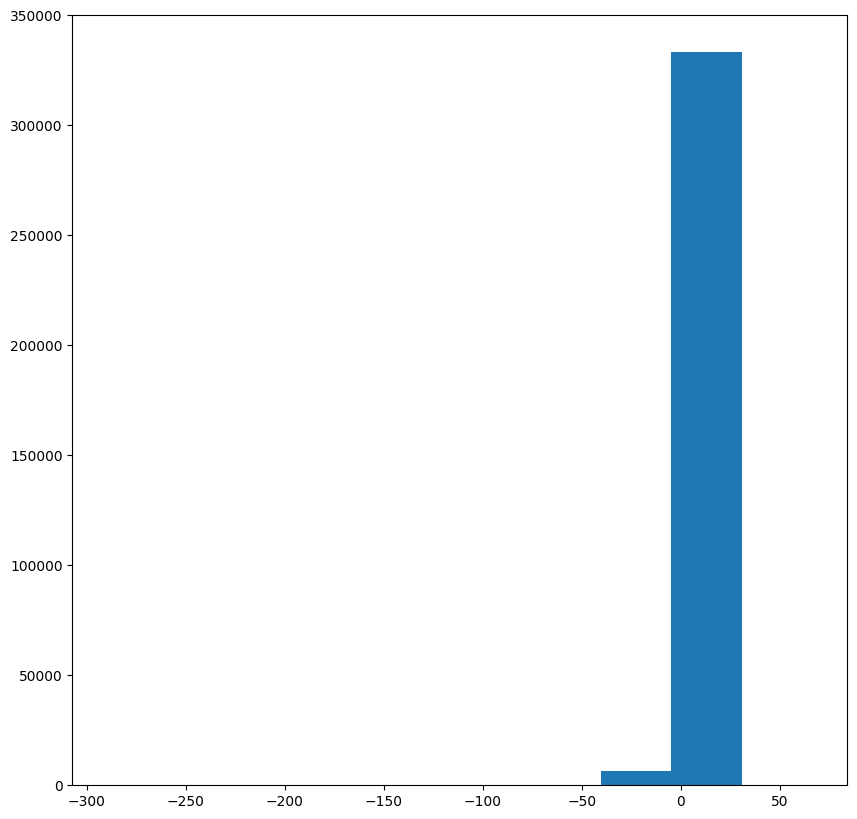

In [12]:
residuals = y_test - y_pred_linreg
fig,ax = plt.subplots(figsize=(10,10))
plt.hist(residuals)

Plotting the residuals over the fitted values we can obeserve that our model suffers from heteroscedacity

### Log Transform the target

In [10]:
# Log transform 
linregLog = LinearRegression()
linregLog.fit(X_train, np.log(y_train))
y_pred_linregLog = linregLog.predict(X_test)

eval_model("Linear Regression with Log transformation", np.log(y_test), y_pred_linregLog)


Linear Regression with Log transformation | MSE: 0.2765 | R²: 0.4582


### Weighted Least Squares

WLS                  | MSE: 3.7877 | R²: 0.7580


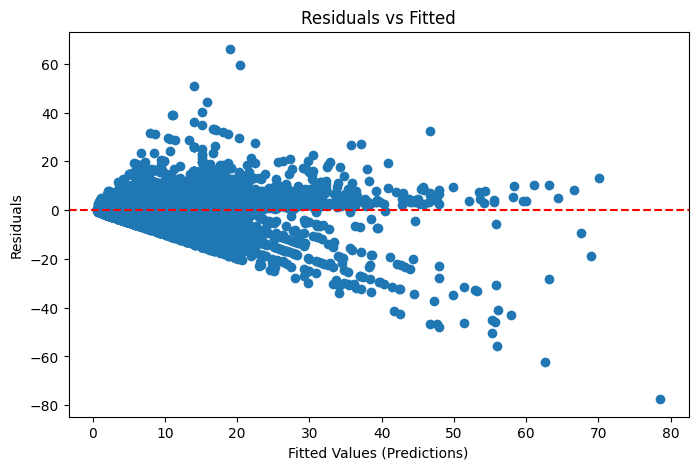

In [11]:
import statsmodels.api as sm

# Estimate variance from residuals of OLS
ols_resid = sm.OLS(y, X).fit().resid
weights = 1 / (ols_resid**2 + 1e-6)  # avoid division by zero

model_wls = sm.WLS(y, X, weights=weights).fit()
y_pred_wls = model_wls.predict(X_test)
eval_model("WLS ", y_test, y_pred_wls)


residuals = y_test['tip_amount'] - y_pred_wls.values.flatten()

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_wls, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values (Predictions)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()

## Regularisation

We can try apply regularisation on the regression model in case the hetersoscedacity is caused by multicollinearity of the predictors

In [38]:


from sklearn.preprocessing import PowerTransformer, QuantileTransformer

# Intlize Power Transformer
qt = QuantileTransformer(output_distribution='normal')

# Numerical Columsn to Transform 
cols_num = ['trip_distance', 'fare_amount','total_amount']

# Fit and Transform
for col in cols_num:
    # Fit and transform
    clean_df[col] = qt.fit_transform(clean_df[[col]])

### Elastic Net

In [ ]:
from sklearn.linear_model import ElasticNetCV

# Automatically tune alpha and l1_ratio using cross-validation
elastic_net = ElasticNetCV(cv=5, l1_ratio=[.1, .5, .7, .9, .95, 1], random_state=42)
elastic_net.fit(X_train, y_train)
y_pred_elastic = elastic_net.predict(X_test)


In [10]:

# Evaluate
eval_model("Elastic Net", y_test, y_pred_elastic)

terms = [f"{coef:.4f}*{feature}" for feature, coef in zip(X_train.columns, elastic_net.coef_)]
equation = f"tip_amount = {elastic_net.intercept_:.4f} + " + " + ".join(terms)
print(equation)

Elastic Net          | MSE: 4.3846 | R²: 0.7198
tip_amount = 0.9210 + 0.1745*fare_amount + 0.0000*Airport_flag + 0.0801*trip_distance + 0.0000*congestion_surcharge_flag + 0.0000*mta_tax_flag


### Sequential Feature Selector

In [88]:
from sklearn.feature_selection import SequentialFeatureSelector

base_model = LinearRegression()

# Forward stepwise selection
sfs = SequentialFeatureSelector(base_model, direction='forward', n_features_to_select='auto', cv=5)
sfs.fit(X_train, y_train)

# Reduced feature set
selected_features = X_train.columns[sfs.get_support()]
print("Selected features:", list(selected_features))

# Fit final model on selected features
X_train_reduced = X_train[selected_features]
X_test_reduced = X_test[selected_features]

stepwise_model = LinearRegression()
stepwise_model.fit(X_train_reduced, y_train)
y_pred_stepwise = stepwise_model.predict(X_test_reduced)

# Evaluate
eval_model("Stepwise Linear", y_test, y_pred_stepwise)
terms = [f'{feature}*{coef:.4f}' for feature, coef in zip(selected_features, stepwise_model.coef_[0])]
equation = f"tip_amount = {stepwise_model.intercept_[0]:.4f} + " + " + ".join(terms)
print(equation)

Selected features: ['fare_amount', 'Airport_flag']
Stepwise Linear      | MSE: 3.4245 | R²: 0.7524
tip_amount = 1.0337 + fare_amount*0.1824 + Airport_flag*0.9078
